In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

In [4]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True,
                               transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
                                batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
                                batch_size=batch_size_test, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets)
print(example_data.shape)

tensor([3, 9, 4, 9, 9, 0, 8, 3, 1, 2, 3, 9, 1, 3, 6, 6, 4, 4, 9, 7, 3, 7, 6, 3,
        4, 8, 4, 6, 8, 6, 1, 1, 1, 1, 0, 0, 1, 8, 4, 0, 1, 2, 7, 9, 3, 2, 3, 8,
        3, 2, 0, 4, 6, 6, 5, 5, 3, 0, 3, 7, 2, 4, 1, 6, 7, 5, 4, 1, 0, 8, 5, 9,
        0, 9, 6, 1, 8, 0, 9, 3, 5, 7, 8, 5, 6, 4, 2, 2, 2, 1, 8, 4, 4, 2, 1, 5,
        9, 3, 7, 0, 4, 1, 7, 2, 2, 6, 5, 1, 2, 6, 1, 3, 1, 2, 7, 4, 1, 3, 2, 9,
        3, 7, 2, 7, 4, 7, 0, 0, 9, 0, 9, 5, 1, 6, 9, 8, 1, 4, 6, 7, 5, 5, 6, 4,
        5, 4, 0, 7, 4, 1, 3, 8, 2, 6, 2, 2, 8, 4, 1, 9, 6, 7, 5, 0, 7, 4, 6, 2,
        6, 8, 7, 9, 8, 0, 7, 4, 2, 4, 9, 0, 4, 6, 5, 6, 6, 4, 4, 8, 3, 8, 0, 9,
        5, 6, 3, 3, 8, 4, 4, 6, 7, 8, 5, 3, 4, 3, 3, 3, 3, 1, 8, 8, 9, 1, 0, 1,
        4, 1, 0, 2, 0, 6, 5, 1, 5, 8, 8, 1, 3, 9, 4, 5, 9, 2, 5, 6, 5, 8, 2, 7,
        4, 1, 6, 8, 7, 9, 3, 3, 4, 4, 5, 4, 9, 8, 2, 9, 1, 6, 7, 1, 0, 5, 1, 9,
        2, 1, 5, 2, 7, 9, 0, 0, 6, 0, 8, 7, 2, 6, 1, 7, 6, 1, 2, 1, 6, 3, 1, 4,
        1, 7, 5, 9, 3, 8, 6, 3, 8, 7, 4,

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27152\3535654827.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


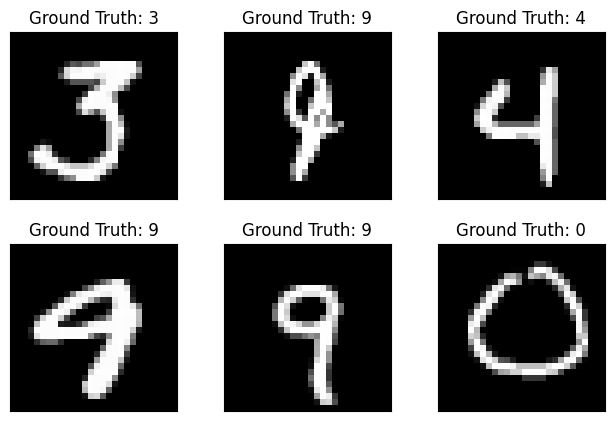

In [6]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title(f"Ground Truth: {example_targets[i]}")
  plt.xticks([])
  plt.yticks([])
plt.show()

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # 第一个卷积层，输入通道为1（灰度图像），输出通道为10，卷积核大小为5x5
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)

        # 第二个卷积层，输入通道为10，输出通道为20，卷积核大小为5x5
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        # 用于在第二个卷积层后引入dropout，以防止过拟合
        self.conv2_drop = nn.Dropout2d()

        # 第一个全连接层，输入特征数为320，输出特征数为50
        self.fc1 = nn.Linear(320, 50)

        # 第二个全连接层，输入特征数为50，输出特征数为10
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # 输入x经过第一个卷积层，然后通过ReLU激活函数和2x2的最大池化层
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # 输入x经过第二个卷积层，然后通过ReLU激活函数、2x2的最大池化层和dropout
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # 将x展平为一维向量，用于连接到全连接层
        x = x.view(-1, 320)

        # 输入x经过第一个全连接层，然后通过ReLU激活函数
        x = F.relu(self.fc1(x))

        # 在训练时进行dropout，以防止过拟合
        x = F.dropout(x, training=self.training)

        # 输入x经过第二个全连接层，输出最终结果
        x = self.fc2(x)

        # 使用log_softmax作为输出层的激活函数
        return F.log_softmax(x)

In [8]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [11]:
import torch.onnx 
import netron

onnx_path = "onnx_model_name.onnx" # 文件名
 
torch.onnx.export(network,example_data, onnx_path) # 导出神经网络模型为onnx格式
 
netron.start(onnx_path) # 启动netron

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Serving 'onnx_model_name.onnx' at http://localhost:8080


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27152\794803888.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


('localhost', 8080)

In [56]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [57]:
def train(epoch):
    # 将神经网络设置为训练模式
    network.train()
    
    # 遍历训练数据集的每个批次
    for batch_idx, (data, target) in enumerate(train_loader):
        # 清零梯度，以防止梯度累积
        optimizer.zero_grad()
        
        # 前向传播，获取模型输出
        output = network(data)
        
        # 计算损失，使用负对数似然损失（NLL Loss）
        loss = F.nll_loss(output, target)
        
        # 反向传播，计算梯度
        loss.backward()
        
        # 优化器更新模型参数
        optimizer.step()
        
        # 打印训练信息，每隔一定批次打印一次
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
            # 记录训练损失和计数器
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            
            # 保存模型和优化器的状态字典
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')


In [58]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

In [61]:
test()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26664\935008181.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.1018, Accuracy: 9671/10000 (97%)


In [59]:
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26664\935008181.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319280
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.290954
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.318535
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.261000
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.259137
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.229576
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.196151
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.181698
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.088444
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.014765
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.818533
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.822772
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.838733
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.530556
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.738141
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.420971
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.369237
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.335397
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.182360
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.056649
Train Epoch: 1 [12800/60000 (

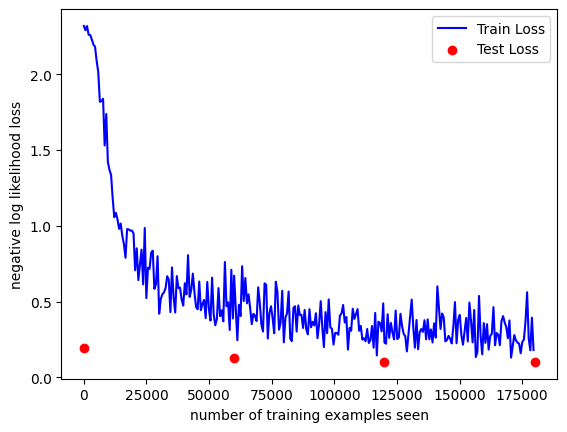

In [62]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26664\935008181.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26664\4082627069.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


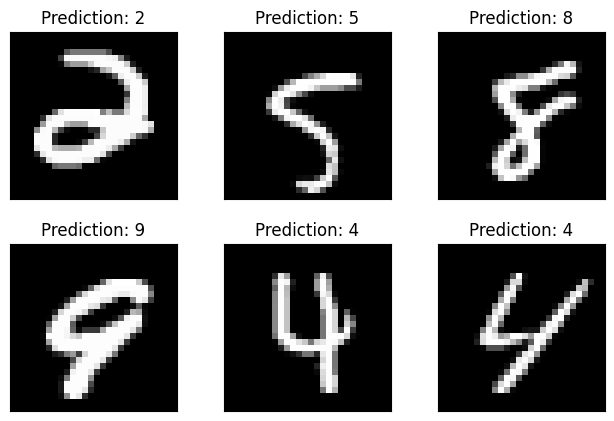

In [49]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    output = network(example_data)
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()